###A introduction to ipython notebooks

This notebook provides a demo of the basic capabilities and use of the MAF python interface

To use this notebook, you need a version of MAF >= 1.0, available via eups installation (eups distrib [install](https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF) sims_maf -t sims, after installing the base LSST software stack requirements). 

To run this notebook you should have,

> setup sims_maf -t sims

within the directory where you ran ipython, i.e.

>ipython notebook IntroductionNotebook.ipynb

In this directory you should have downloaded the survey simulation database and unziped it

>wget http://ops2.tuc.noao.edu/runs/enigma_1189/data/enigma_1189_sqlite.db.gz

>gunzip enigma_1189.db.gz


In [1]:
# import matplotlib to show plots inline.
%matplotlib inline   
import matplotlib.pyplot as plt

Import the sims_maf modules needed.

In [2]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

###Defining what we will measure and output

A `MetricBundle` combines a particular `Metric`, a `Slicer`, and a sqlconstraint. 
- a `metric` calculates some quantity that you want to measure (e.g. the mean value of an attribute such as the airmass). 
- a `slicer` takes the list of visits from a simulated survey and orders or groups them (e.g. by night or by region on the sky).
- a sqlconstraint applies a sql selection to the visits you want to select from the simulated survey database.

After a MetricBundle has been run it stores the metric values calculated at each point of the slice data. You can also add additional provenance/metadata information to a given MetricBundle, in the form of the (opsim) runName and a metadata comment. This information will be used to generate output filenames and plot labels. 

To create a `MetricBundle`, we will first generate a [`Metric`](https://confluence.lsstcorp.org/display/SIM/MAF+Metrics) and [`Slicer`](https://confluence.lsstcorp.org/display/SIM/MAF+Slicers), and a SQL constraint, and then combine them in a  `MetricBundle`.

As an example, here we'll get set up to calculate the maximum airmass value, at each point in a healpix grid.

In [3]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric1 = metrics.MaxMetric('airmass')

# slicer = a grouping or subdivision of visits for the simulated survey based on their position on the sky 
# (using a Healpix grid)
slicer1 = slicers.HealpixSlicer(nside=64)

# sqlconstraint = the sql query (or 'select') that selects all visits in r band.
sqlconstraint= 'filter = "r"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
maxairmassSky = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


###Choosing the simulated survey database and the directory to output the results
The input data is queried from a database (usually a SQLite database).
The outputs are tracked in another database in the results directory 'outDir'

In [4]:
opsdb = db.OpsimDatabase('sqlite:///enigma_1189_sqlite.db')
outDir = 'output_directory'
resultsDb = db.ResultsDb(outDir=outDir)

We can combine multiple MetricBundles and run them all at once by placing them in a dictionary. For now we will use just the airmass MetricBundle. 

The dictionary enables us to name the MetricBundle, which makes it easier to retrieve the information later (if we have many MetricBundles)

In [5]:
bundleDict = {'maxairmassSky':maxairmassSky}

We generate the outputs by combining the bundle dictionary with the input database and output directories and database. This is called a MetricBundleGroup.

Note that all MetricBundles in this group must have the same sql constraint

The MetricBundleGroup will now query the data from the opsim database and calculate the metric values, using the 'runAll' method. Note that MAF determines what columns you need from the database for your metrics and slicers, and only queries for those. MAF calculates the metrics in an efficient manner, caching results where possible and iterating through each slicer only once for all related metrics and saves everything to disk. 

In [6]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database with constraint filter = "r"
Found 544710 visits
Running:  ['maxairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


###Visualizing the output
We can now plot the figures generated by running the metrics. This by default comes as three plots
- the maximum airmass as a function of position on the sky (in a Healpix projection)
- a histogram of the airmass distribution for the pixels in the Healpix projection
- the angular powerspectrum of the maximum airmass

Plotting.
monopole: 1.90958  dipole: lon: 97.791, lat: 75.9139, amp: 0.331237
Plotting complete.


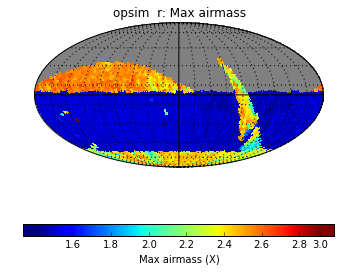

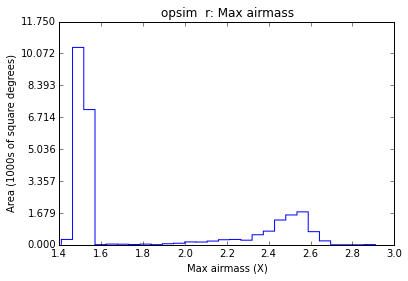

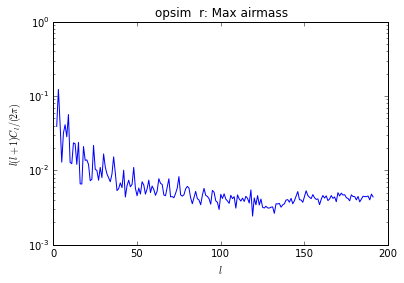

In [7]:
group.plotAll(closefigs=False)

### Extending the analysis: adding more metrics and more information

We create a new `MetricBundle` (nvisitsSky), that works with the same slicer and sql constraint but now counts the number of visits at each point in the healpix grid. To do this we use the 'CountMetric' to count the number of exposure MJD's in each Healpix pixel 

In [8]:
metric2 = metrics.CountMetric('expMJD')
nvisitsSky = metricBundles.MetricBundle(metric2, slicer1, sqlconstraint)

We can also add ["summary metrics"](https://confluence.lsstcorp.org/display/SIM/MAF+Summary+Statistics) to each MetricBundle. These metrics  generate statistical summaries of the metric data values (e.g. the means of the number of visits per point on the sky).

In [9]:
summaryMetrics = [metrics.MinMetric(), metrics.MedianMetric(), metrics.MaxMetric(), metrics.RmsMetric()]
maxairmassSky.setSummaryMetrics(summaryMetrics)
nvisitsSky.setSummaryMetrics(summaryMetrics)

We can use the same metric but change the slicer (in this case grouping the visits by night) so we plot the maximum airmass and the number of visits per night)

In [10]:
# A slicer that will calculate a metric after grouping the visits into subsets corresponding to each night.
slicer2 = slicers.OneDSlicer(sliceColName='night', binsize=1, binMin=0, binMax=365*10)

# We can combine these slicers and metrics and generate more metricBundles
nvisitsPerNight = metricBundles.MetricBundle(metric1, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)
maxairmassPerNight = metricBundles.MetricBundle(metric2, slicer2, sqlconstraint, summaryMetrics=summaryMetrics)

###Grouping everything together 
As long as a MetricBundle has the same SQL constraint we can group them together into the dictionary 

In [11]:
bundleDict = {'maxairmassSky':maxairmassSky, 'maxairmassPerNight':maxairmassPerNight, 
        'nvisitsSky':nvisitsSky, 'nvisitsPerNight':nvisitsPerNight}

and combine them into a MetricBundleGroup, which can all be run (efficiently) together

Querying database with constraint filter = "r"
Found 544710 visits
Running:  ['nvisitsPerNight', 'maxairmassPerNight']
Completed metric generation.
Running:  ['maxairmassSky', 'nvisitsSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 1.90958  dipole: lon: 97.791, lat: 75.9139, amp: 0.331237
monopole: 191.913  dipole: lon: 64.7881, lat: -52.0156, amp: 26.8356
Plotting complete.


Optimal bin calculation tried to make 655 bins, returning 200


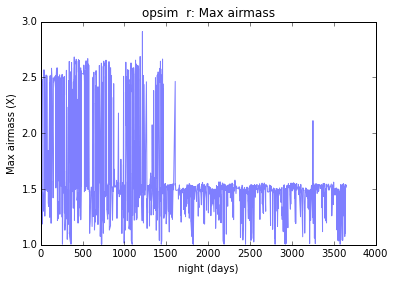

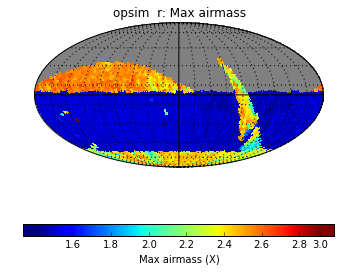

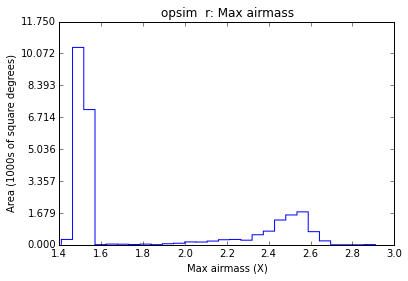

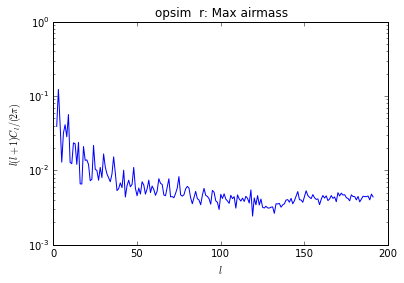

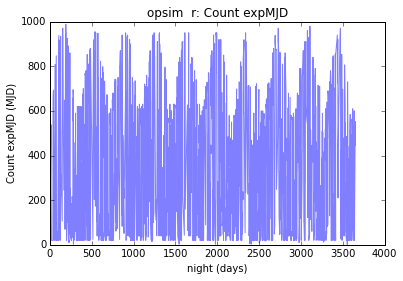

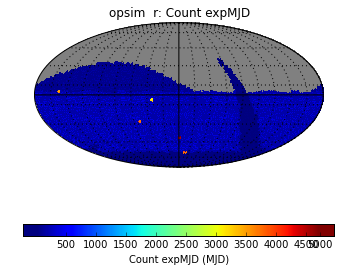

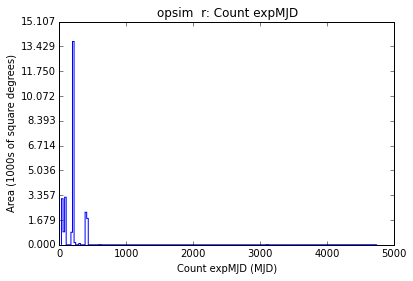

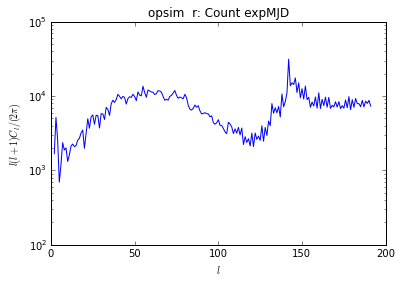

In [12]:
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

### Accessing the data generated by a metric

The results of the metric calculation are stored as an attribute in each metricbundle, as 'metricValues' - a numpy masked array. The results of the summary statistics are also stored in each metricbundle, in an attribute called 'summaryValues', which is a dictionary of the summarymetric name and value. 

For nvisitsSky, the metricValues are an array of the number of visits on the sky for each healpix pixel and the summaryValues are the mean, median etc of the these values

In [13]:
print "Array with the number of visits per pixel:", nvisitsSky.metricValues

Array with the number of visits per pixel: [-- -- -- ..., 30.0 30.0 60.0]


In [14]:
print "Summary of the max, median, min, and rms of the number of visits per pixel", nvisitsSky.summaryValues

Summary of the max, median, min, and rms of the number of visits per pixel {'Max': 4739.0, 'Rms': 192.03189557237977, 'Median': 200.0, 'Min': 30.0}
